In [4]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot
#os.chdir('C:/Users/user/Desktop/Yash/CReST/Files/Correlation')
formosa = pd.read_csv('Without_Errors.csv', index_col = 'TagName')
series = formosa.iloc[:500,1]
series.head()

TagName
2017-10-12 00:00:00    4.603224
2017-10-12 00:05:00    4.585253
2017-10-12 00:10:00    4.581443
2017-10-12 00:15:00    4.591214
2017-10-12 00:20:00    4.593621
Name: MLEGP_1A_PIC_4120.PV, dtype: float64

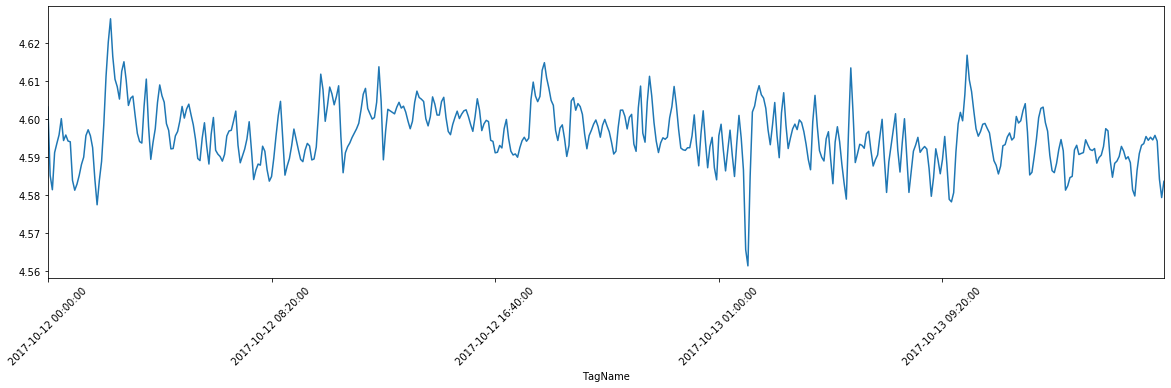

In [5]:
pyplot.figure(figsize = [20,5])
series.plot()
pyplot.xticks(rotation=45)
pyplot.show()


In [ ]:
# determine the 

# check if the time series is stationary 
The purpose of differencing it to make the time series stationary.

But you need to be careful to not over-difference the series. Because, an over differenced series may still be stationary, which in turn will affect the model parameters.

So how to determine the right order of differencing?

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

Let’s see how to do it with an example.

First, I am going to check if the series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.

Why?

Because, you need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

Reference 
[1]. https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [9]:
df = series
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.069228
p-value: 0.000000


The p-value is 0 so we don't have to compute the the value of 'd'

# how to determine q:
Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

Let’s see the autocorrelation plot of the differenced series.

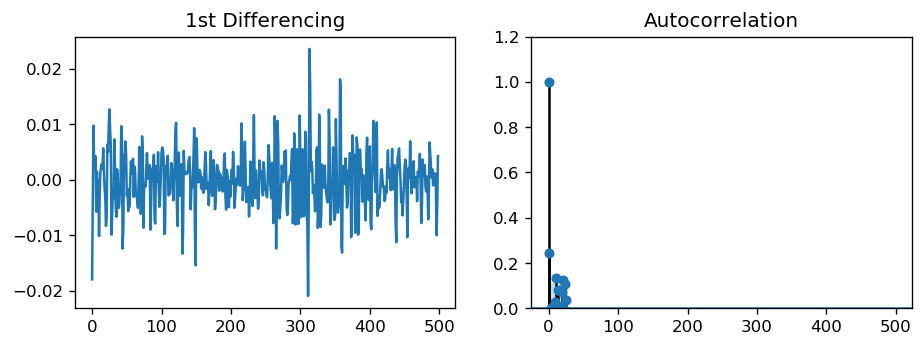

In [25]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(np.diff(df.values)); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(np.diff(df.values), ax=axes[1])

plt.show()

Couple of lags are well above the significance line. So, let’s tentatively fix q as 1. When in doubt, go with the simpler model that sufficiently explains the Y.

# p determination


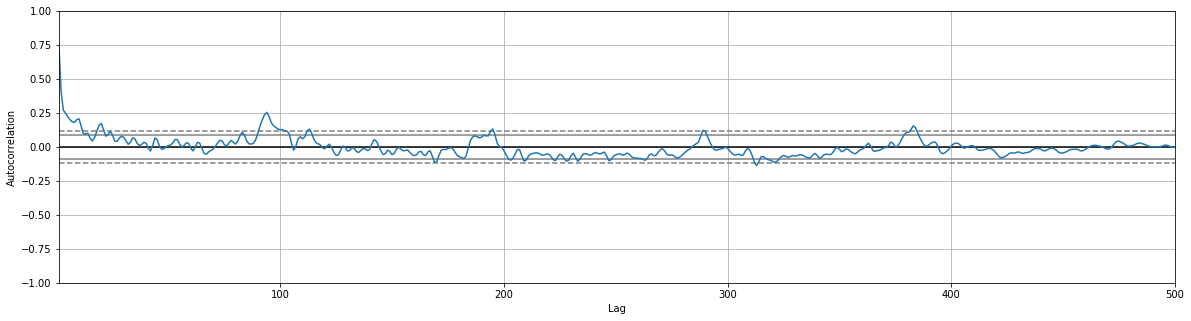

In [10]:

from pandas.plotting import autocorrelation_plot
pyplot.figure(figsize = [20,5]) 
autocorrelation_plot(series)
pyplot.show()

/Users/sumitpandey/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  % freq, ValueWarning)


                               ARMA Model Results                               
Dep. Variable:     MLEGP_1A_PIC_4120.PV   No. Observations:                  500
Model:                      ARMA(10, 1)   Log Likelihood                2058.343
Method:                         css-mle   S.D. of innovations              0.004
Date:                  Sat, 04 Apr 2020   AIC                          -4090.685
Time:                          15:30:15   BIC                          -4035.895
Sample:                      10-12-2017   HQIC                         -4069.186
                           - 10-13-2017                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           4.5958      0.001   4252.908      0.000       4.594       4.598
ar.L1.MLEGP_1A_PIC_4120.PV      0.4306      0.095      4.509    

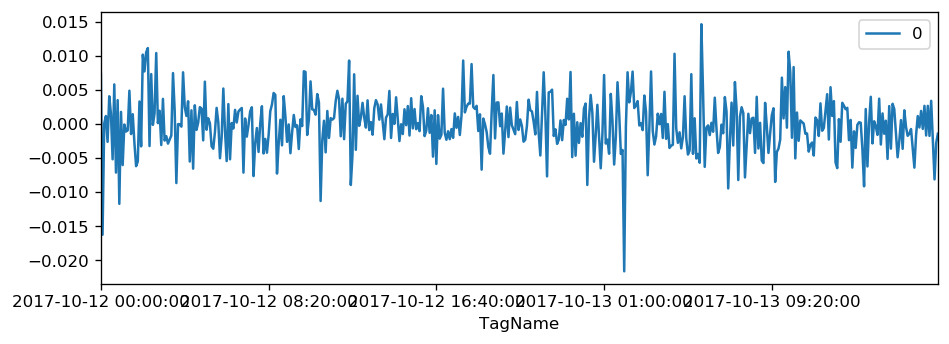

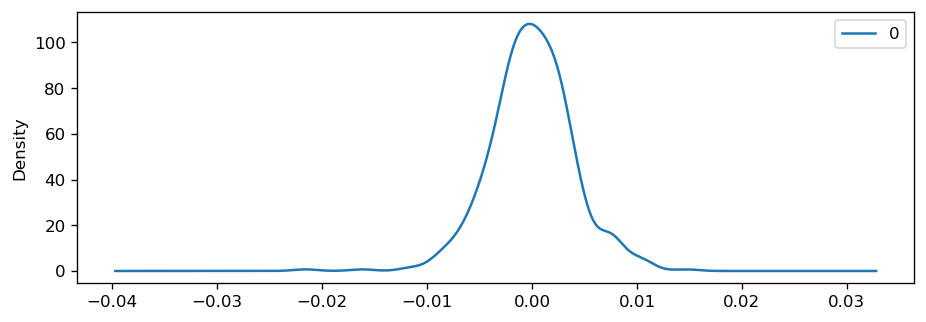

                0
count  500.000000
mean    -0.000011
std      0.003974
min     -0.021590
25%     -0.002275
50%     -0.000009
75%      0.002344
max      0.014668


In [26]:
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(series, order=(10,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [27]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(10,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('for ',t, ': ','predicted=%f, expected=%f' % (yhat, obs))


for  0 :  predicted=4.601928, expected=4.598485
for  1 :  predicted=4.594341, expected=4.592290
for  2 :  predicted=4.594343, expected=4.595045
for  3 :  predicted=4.597976, expected=4.597470
for  4 :  predicted=4.596644, expected=4.598720
for  5 :  predicted=4.599537, expected=4.597277
for  6 :  predicted=4.596029, expected=4.599826
for  7 :  predicted=4.601974, expected=4.599120
for  8 :  predicted=4.596551, expected=4.596771
for  9 :  predicted=4.597264, expected=4.593446
for  10 :  predicted=4.592740, expected=4.589391
for  11 :  predicted=4.589642, expected=4.586703
for  12 :  predicted=4.588382, expected=4.599367
for  13 :  predicted=4.607301, expected=4.606288
for  14 :  predicted=4.601322, expected=4.598242
for  15 :  predicted=4.593205, expected=4.591733
for  16 :  predicted=4.593473, expected=4.589978
for  17 :  predicted=4.590828, expected=4.589012
for  18 :  predicted=4.589589, expected=4.594866
for  19 :  predicted=4.598713, expected=4.596724
for  20 :  predicted=4.594010,

for  167 :  predicted=4.592129, expected=4.584235
for  168 :  predicted=4.581606, expected=4.579379
for  169 :  predicted=4.584137, expected=4.583659


Test MSE: 0.000


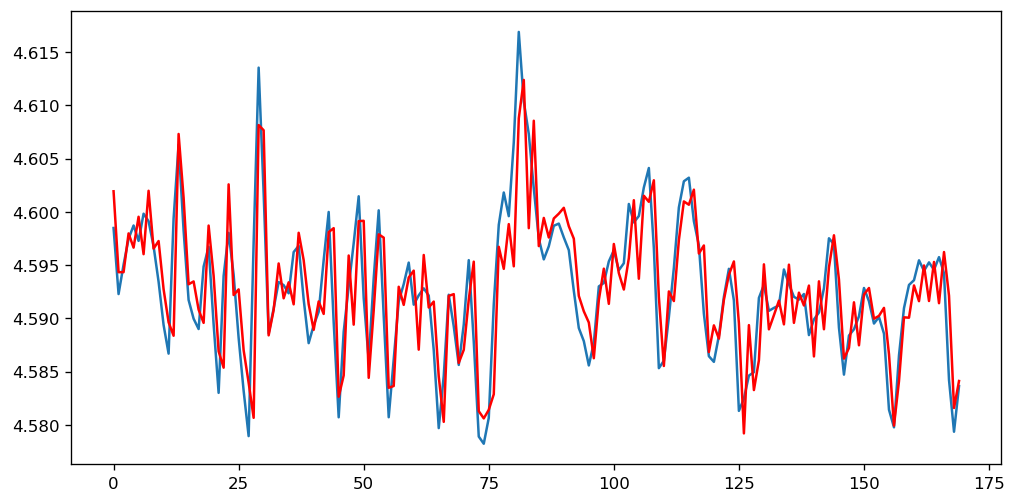

In [28]:
from sklearn.metrics import mean_squared_error
 
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot

pyplot.figure(figsize = [10,5])
pyplot.plot(test,  label='real sensor values')
pyplot.plot(predictions, color='red')
pyplot.show()